In [10]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from AES import*
from Model.CNN import cnn_classifier
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import mode
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle

In [11]:
def Evalution_CUA(models, profiling_Data_path, Target_Data_path, p_attack_to_label_total, p_v_box):
    acc_total=[]
    # Main experiment loop (single iteration: 10000 traces only)
    for t_num in range(1000, 10001, 1000):  # Range generates [10000] only
        # Byte position iteration (0-15 for 16-byte blocks)
        for byte in range(0, 16):
            # Load profiling traces (template attack dataset)
            profiling_traces, _, _, _, _, _ = load_CW_Source(
                in_file=profiling_Data_path,
                sec=18000,  # Fixed security parameter from original implementation
                byte=byte
            )
            # Load attack traces and associated data
            X_attack, label_V, p_attack = load_CW_Target(
                in_file=Target_Data_path,
                byte=byte
            )

            # Slice datasets with shuffling 
            X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)

            
            X_attack_shuffle = X_attack[:t_num]  # Use first t_num traces
            label_V_shuffle = label_V[:t_num]
            p_attack_shuffle = p_attack[:t_num]
            

            # Preprocessing pipeline
            # 1. Standardization (zero-mean, unit-variance)
            scaler = preprocessing.StandardScaler()
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)
            
            # # 2. Normalization (scale to [0,1] range)
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)

            # Model inference using pre-trained byte-specific model
            predictions= models[byte].predict(X_attack_shuffle)  # models loaded externally

            # Process prediction results
            A = np.squeeze(predictions)  # Remove singleton dimensions
            B = np.squeeze(p_attack_shuffle)
            df = pd.DataFrame({'traces': list(A), 'plaintext': list(B)})  # Maintain column names
            
            # Aggregate predictions by plaintext value
            sum_by_plaintext = df.groupby('plaintext')['traces'].sum()
            
            # Populate key guess matrix
            for j in range(256):  # All possible byte values (0-255)
                if j in sum_by_plaintext.index:  # Check if plaintext exists in data
                    # Store index with maximum prediction sum
                    p_v_box[byte, j] = np.argmax(sum_by_plaintext.loc[j])
                else:
                    p_v_box[byte, j] = -1  # Mark missing entries

        # Calculate byte-wise accuracy
        acc = []
        for i in range(0, 16):  # Iterate through all bytes
            total_num = 0.0  # Total valid predictions counter
            acc_num = 0.0    # Correct predictions counter
            for p in range(256):  # All possible plaintext values
                if p_v_box[i][p] == -1:  # Skip invalid entries
                    continue
                if p_v_box[i][p] == p_attack_to_label_total[i][p]:  # Compare with ground truth
                    acc_num += 1
                total_num += 1
            # Store accuracy for current byte
            acc.append(acc_num / total_num if total_num > 0 else 0.0)
        acc_total.append(acc)  # Store experiment results
    
    return acc_total

<b> Source Model-Target(SM4)

In [12]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/SM4_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D1.h5'
    model.load_weights(model_path + model_name)
    models.append(model)  

SM4_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box)

SM4_ACC_avg = np.mean(np.array(SM4_ACC), axis=1)
SM4_ACC_avg

array([0.84224017, 0.9289321 , 0.953125  , 0.9609375 , 0.96557617,
       0.96801758, 0.96850586, 0.96777344, 0.9699707 , 0.96875   ])

<b> Transfer Model-Target(Skinny)

In [13]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/Skinny_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D1.h5'
    model.load_weights(model_path + model_name)
    models.append(model)  

Skinny_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box)

Skinny_ACC_avg = np.mean(np.array(Skinny_ACC), axis=1)
Skinny_ACC_avg

array([0.85751434, 0.93491977, 0.95654297, 0.96240234, 0.96655273,
       0.96459961, 0.96606445, 0.96777344, 0.96557617, 0.96801758])

<b> Result Visualization

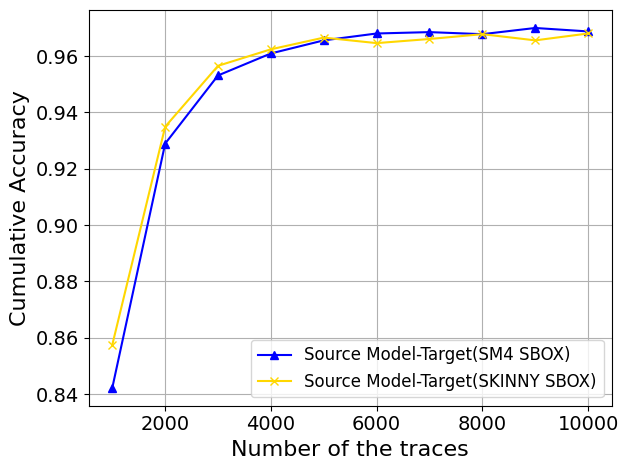

In [18]:
x = np.arange(1000, 10001, 1000)
plt.plot(x, SM4_ACC_avg[:],color='b', marker='^',label='Source Model-Target(SM4 SBOX)')
plt.plot(x, Skinny_ACC_avg[:],color='gold',marker='x',label='Source Model-Target(SKINNY SBOX)')
plt.grid(True)  
plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel('Cumulative Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('AES-X_CA.pdf')
plt.savefig('AES-X_CA.png')
plt.show()